In [63]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

from sumpy.recurrence import get_recurrence

import sympy as sp
from sympy import hankel1

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

In [64]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)
n_init, order, r = get_processed_and_shifted_recurrence(laplace2d)

w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w
n_init, _, recur_helmholtz = get_processed_and_shifted_recurrence(helmholtz2d)

In [65]:
def scale_recurrence(r):
    #We want to subsitute s(i) r^i_{ct} = g(i)
    g = sp.Function("g")
    s = sp.Function("s")
    n = sp.symbols("n")
    rct = sp.symbols("r_{ct}")

    r_new = r*rct**n
    for i in range(order):
        r_new = r_new.subs(s(n-i),g(n-i)/(rct**(n-i)))

    return r_new

In [66]:
r_new = scale_recurrence(r)

In [67]:
max_abs = .0000001
var = _make_sympy_vec("x", 2)
rct = sp.symbols("r_{ct}")
g = sp.Function("g")
s = sp.Function("s")
n = sp.symbols("n")
coord_dict = {var[0]: 1, var[1]: 1}

In [68]:
r_new_helmholtz = recur_helmholtz.subs(s, g)

In [ ]:
r_new_helmholtz = recur_helmholtz.subs(s, g)

In [69]:
r_new = r_new.subs(rct, 1)
r_new

(-1)**(n + 1)*((-1)**(n - 3)*(n + (n - 2)**3 - 2*(n - 2)**2 - 2)*g(n - 3)/(x0**3 + x0*x1**2) + (-1)**(n - 2)*(-n + 3*(n - 2)**2 + 2)*g(n - 2)/(x0**2 + x1**2) + (-1)**(n - 1)*(3*x0**2*(n - 2) + x0**2 + x1**2*(n - 2) - x1**2)*g(n - 1)/(x0**3 + x0*x1**2))

In [70]:
r_new_shifted_1 = r_new.subs(n, n-1)
r_new_shifted_3 = r_new.subs(n, n-3)

In [71]:
poly1 = sp.poly(r_new.subs(g(n-1), r_new_shifted_1), [g(n-2), g(n-3), g(n-4)])
new_recur = g(n-2) * poly1.coeffs()[0].subs((-1)**(2*n), 1) + g(n-3) * poly1.coeffs()[1].subs((-1)**(2*n), 1) + g(n-4) * poly1.coeffs()[2].subs((-1)**(2*n), 1)
new_recur

(6*n**2*x0**4 + 3*n**2*x0**2*x1**2 + n**2*x1**4 - 26*n*x0**4 - 21*n*x0**2*x1**2 - 7*n*x1**4 + 26*x0**4 + 30*x0**2*x1**2 + 12*x1**4)*g(n - 2)/(x0**6 + 2*x0**4*x1**2 + x0**2*x1**4) + (3*n**4*x0**2 + n**4*x1**2 - 38*n**3*x0**2 - 14*n**3*x1**2 + 175*n**2*x0**2 + 73*n**2*x1**2 - 344*n*x0**2 - 168*n*x1**2 + 240*x0**2 + 144*x1**2)*g(n - 4)/(x0**6 + 2*x0**4*x1**2 + x0**2*x1**4) + (-8*n**3*x0**2 - 2*n**3*x1**2 + 64*n**2*x0**2 + 20*n**2*x1**2 - 164*n*x0**2 - 66*n*x1**2 + 132*x0**2 + 72*x1**2)*g(n - 3)/(x0**5 + 2*x0**3*x1**2 + x0*x1**4)

In [72]:
def compute_derivatives(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))
    derivs = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                        for i in range(p)]
    return derivs
derivs = compute_derivatives(10)

In [73]:
k = 1
var = _make_sympy_vec("x", 2)
var_t = _make_sympy_vec("t", 2)
abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                    (var[1]-var_t[1])**2)
g_x_y = (1j/4) * hankel1(0, k * abs_dist)
derivs_helmholtz = [sp.diff(g_x_y,
                    var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                            for i in range(7)]

In [79]:
def evaluate_recurrence_lamb(coord_dict, rct_val, recur, p, derivs_list):
    subs_dict = {}
    subs_dict[g(-2)] = 0
    subs_dict[g(-1)] = 0
    subs_dict[g(0)] = derivs_list[0].subs(coord_dict).subs(rct, rct_val)
    subs_dict[g(1)] = derivs_list[1].subs(coord_dict).subs(rct, rct_val) * rct_val
    subs_dict[g(2)] = derivs_list[2].subs(coord_dict).subs(rct, rct_val) * rct_val**2
    var = _make_sympy_vec("x", 2)
    for i in range(3, p):
        exp = get_recurrence(recur.subs(rct, rct_val), i)
        f = sp.lambdify([var[0], var[1], g(i-1), g(i-2), g(i-3), g(i-4), g(i-5)], exp)
        subs_dict[g(i)] = f(coord_dict[var[0]], coord_dict[var[1]], subs_dict[g(i-1)], subs_dict[g(i-2)],
                            subs_dict[g(i-3)], subs_dict[g(i-4)], subs_dict[g(i-5)])
    subs_dict.pop(g(-2))
    subs_dict.pop(g(-1))
    return np.array(list(subs_dict.values()))

In [80]:
def evaluate_true(coord_dict, rct_val, p, derivs_list):
    retMe = []
    for i in range(p):
        exp = (derivs_list[i]*rct_val**i)
        f = sp.lambdify(var, exp)
        retMe.append(f(coord_dict[var[0]], coord_dict[var[1]]))
    return np.array(retMe)

In [81]:
def compute_error(pw, recur):
    x_coord = 10**(-pw)
    y_coord = 1
    var = _make_sympy_vec("x", 2)
    coord_dict = {var[0]: x_coord, var[1]: y_coord}

    rct_val = 1
    exp = evaluate_recurrence_lamb(coord_dict, rct_val, recur, 10)
    true = evaluate_true(coord_dict, rct_val, 10)

    return np.abs(exp-true)/np.abs(true)

In [82]:
def compute_error_coord(recur, loc, order, derivs_list):
    var = _make_sympy_vec("x", 2)
    coord_dict = {var[0]: loc[0], var[1]: loc[1]}

    rct_val = 1
    exp = evaluate_recurrence_lamb(coord_dict, rct_val, recur, order+1, derivs_list)[order].evalf()
    
    true = derivs_list[order].subs(coord_dict).evalf()

    return (np.abs(exp-true)/np.abs(true))

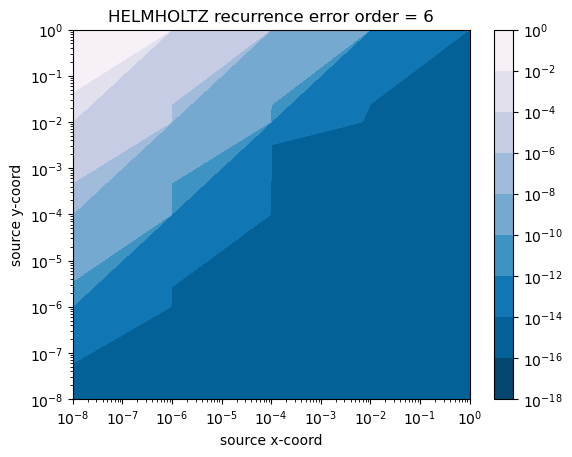

In [86]:
res = 5
x_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
y_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
res=len(x_grid)
order_plot = 6
plot_me = np.empty((res, res))
for i in range(res):
    for j in range(res):
        if abs(x_grid[i]) == abs(y_grid[j]):
            plot_me[i, j] = 1e-16
        else:
            plot_me[i,j] = compute_error_coord(r_new_helmholtz, np.array([x_grid[i],y_grid[j]]), order_plot, derivs_helmholtz)
            if plot_me[i,j] == 0:
                plot_me[i, j] = 1e-16
                
fig, ax = plt.subplots()
cs = ax.contourf(x_grid, y_grid, plot_me.T, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel("source x-coord")
plt.ylabel("source y-coord")
plt.title("HELMHOLTZ recurrence error order = "+str(order_plot))
plt.show()

# Avoiding Cat Cancellation: Attempt 1
The question is can we avoid catastrophic cancellation in the recurrence when $x_0 << 1$? Where $(x_0, y_0)$ is the location of the source?

If we formulate a recurrence for
$$
g(i, x_0, y_0) = \frac{d^i}{dx^i}|_{x = 0} G(x, y) r_{ct}^i
$$
we will inevitably get catastrophic cancellation when $x_0 << y_0$. Suppose we let $r_{ct} = x_0$ (we can scale up and down later with the true $r_{ct}$) and have
$$
g(n, x_0, y_0) = f_1(x_0, y_0, n-1) g(n-1, x_0, y_0) + f_2(x_0, y_0, n-2) g(n-2, x_0, y_0) + f_3(x_0, y_0, n-3) g(n-3, x_0, y_0)
$$
we could treat $g(n-1, x_0, y_0), g(n-2, x_0, y_0), g(n-3, x_0, y_0)$ as constants and taylor expand  $f_i(x_0, y_0, j)$ when $x_0  << y_0$. So instead we get for example:
$$
g(2) = -g(1) + \frac{4g(1)}{x_1^2} \frac{x_0^2}{2!} - \frac{48 g(1)}{x_1^4} \frac{x_0^4}{4!} 
$$
$$
g(3) = -\frac{4(g(1)-2g(2))}{x_1^2} \frac{x_0^2}{2!} - \frac{48 (g(1)-2g(2))}{x_1^4} \frac{x_0^4}{4!} 
$$
$$
g(4) = g(3) - \frac{4(g(1)-5g(2)+3g(3))}{x_1^2 }  \frac{x_0^2}{2!} - \frac{48(g(1)-5g(2)+3g(3))}{x_1^4} \frac{x_0^4}{4!} 
$$
$$
g(5) = 2g(4) + \frac{8(3g(2)-6g(3)+2g(4))}{x_1^2} \frac{x_0^2}{2!}
$$

In [ ]:
def generate_specialized_formula(i, order):
    a = sp.cancel(r_new.subs(rct, var[0]).subs(n, i))
    res = 0
    for j in range(order+1):
        res += sp.simplify(sp.diff(a, var[0], j).subs(var[0], 0)) * var[0]**j/math.factorial(j)
    return res

In [ ]:
def evaluate_specialized_formula(coord_dict, p, rct_val, order_approx):
    subs_dict = {}
    subs_dict[g(-2)] = 0
    subs_dict[g(-1)] = 0
    subs_dict[g(0)] = derivs[0].subs(coord_dict)
    subs_dict[g(1)] = derivs[1].subs(coord_dict) * rct_val
    var = _make_sympy_vec("x", 2)
    for i in range(2, p):
        exp = generate_specialized_formula(i, order_approx)
        f = sp.lambdify([var[0], var[1], g(i-1), g(i-2), g(i-3)], exp)
        subs_dict[g(i)] = f(coord_dict[var[0]], coord_dict[var[1]], subs_dict[g(i-1)],
                            subs_dict[g(i-2)], subs_dict[g(i-3)])
    subs_dict.pop(g(-2))
    subs_dict.pop(g(-1))
    return np.array(list(subs_dict.values()))

In [ ]:
def compute_error_using_specialized_formula(pw, order_approx):
    x_coord = 10**(-pw)
    y_coord = 1
    var = _make_sympy_vec("x", 2)
    coord_dict = {var[0]: x_coord, var[1]: y_coord}

    rct_val = x_coord
    exp = evaluate_specialized_formula(coord_dict, 9, rct_val, order_approx)
    true = evaluate_true(coord_dict, rct_val, 9)
    print(exp)
    print(true)
    return np.abs(exp-true)/np.abs(true)

# Avoiding Cat Cancel 1.5

If we have $x_0 << x_1$ then the following expressions are a good approximation\
to coefficients for a Taylor expansion of a Laplace kernel at the origin with\
source at $(x_0, x_1)$:

In [ ]:
k = 1
var = _make_sympy_vec("x", 2)
var_t = _make_sympy_vec("t", 2)
abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                    (var[1]-var_t[1])**2)
g_x_y = (1j/4) * hankel1(0, k * abs_dist)
derivs_helmholtz = [sp.diff(g_x_y,
                    var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                            for i in range(7)]

In [ ]:
[sp.diff(derivs[i], var[0], 0) for i in range(0,15,1)]

In [ ]:
[sp.diff(derivs_helmholtz[i], var[0], 0) for i in range(0,7,1)]

In [ ]:
[sp.diff(derivs[i], var[0], 0).subs(var[0], 0) for i in range(0,15,1)]

In [ ]:
a1 = [sp.diff(derivs_helmholtz[i], var[0], 0).subs(var[0], 0) for i in range(0,7,1)]
a1

In [ ]:
r1 = sp.simplify(a1[0])
sp.diff(r1, var[1])

In [ ]:
r2 = sp.simplify(a1[2])
sp.diff(r2, var[1])

In [ ]:
sp.simplify(a1[4])

In [ ]:
[sp.diff(derivs[i], var[0], 2).subs(var[0], 0)  for i in range(0,15,1)]

In [ ]:
a = [sp.diff(derivs_helmholtz[i], var[0], 2).subs(var[0], 0) for i in range(0,7,1)]
a

In [ ]:
sp.simplify(a[0])

In [ ]:
sp.simplify(a[2])

In [ ]:
[sp.diff(derivs[i], var[0], 4).subs(var[0], 0) for i in range(0,15,1)]

In [ ]:
[sp.diff(derivs_helmholtz[i], var[0], 4).subs(var[0], 0) for i in range(0,4,1)]

In [ ]:
[math.factorial(2*n_v+1) for n_v in range(7)]

Suppose
$$
f(n) = f(n-2) (2n+1)(2n) = 4n^2 f(n-2) - 2n f(n-1)
$$
what PDE do we satisfy? This isn't obvious since
$$
y = c y'' - dy'
$$
something of that form. What if it's just the old recurrence but simplified??? When $x_0 << 1$?


# Avoiding Cat Cancellation Attempt 2

We have
$$
\text{ Given } g(0), g(1), rct = 1
$$
$$
g(1) = \frac{1}{2\pi} \frac{x_0}{x_0^2 + x_1^2}
$$
$$
g(2) = \frac{x_0^2 -x_1^2}{x_0^3 +x_0 x_1^2} g(1)
$$
$$
g(3) = \frac{4x_0 g(2)}{x_0^2 +  x_1^2}  - \frac{2 g (1)}{x_0^2 + x_1^2}
$$
$$
g(4) = \frac{(7 x_0^2 + x_1^2)g(3)}{x_0^3 + x_0x_1^2}  - \frac{10g(2)}{x_0^2 + x_1^2} + \frac{2g(1)}{x_0^3 + x_0 x_1^2}
$$

Rewriting as an odd-even recurrence we get:
$$
g(2) =  \frac{1}{2\pi} \frac{x_0^2 -x_1^2}{(x_0^2 + x_1^2)^2}   
$$
$$
g(3) =  \frac{6x_0^2 -2x_1^2}{(x_0^2 + x_1^2)^2} g(1)
$$
$$
g(4) = \frac{(7 x_0^2 + x_1^2)}{x_0^2 + x_1^2} \left(\frac{4 g(2)}{x_0^2 +  x_1^2}  - \frac{1 }{\pi(x_0^2 + x_1^2)^2} \right) - \frac{10g(2)}{x_0^2 + x_1^2} + \frac{1}{x_0^2 + x_1^2} \frac{1}{\pi} \frac{1}{x_0^2 + x_1^2}
$$
$$
g(4) = \frac{18x_0^2 - 6x_1^2}{(x_0^2 + x_1^2)^2} g(2) + \frac{-(7 x_0^2 + x_1^2) + 1}{\pi(x_0^2 + x_1^2)^2}
$$

In [ ]:
def odd_even(i):
    #Pseudocode
    #Step 1 use extract_idx_terms from recurrence
    #Use odd-even to recursively? substitute odd or even terms
    #Should take in dictionary?
    #The problem is when we try and replace the smallest even
    #term, we get a smaller even term. Have we already computed
    #Are we even only to a certain order????
    #Yes you can assume every even/odd terms has been computed accurately
    #Let us try with a dictionary first
    return 0

In [ ]:
'''
x_plot = [i for i in range(len(compute_error(0)))]
for i in range(1, 4):
    plt.semilogy(x_plot, compute_error(i), label=str(10**(-i)))
plt.xlabel("order of derivative being computed")
plt.ylabel("absolute error")
plt.title("recurrence error vs order for different source-locations")
plt.legend(title='ratio of x_{coord_src}/y_{coord_src}')
plt.show()
'''

Suppose we have a relation
$$
f(1, x_0, x_1) g_1(x_0, x_1) + f(2, x_0, x_1) g_2(x_0, x_1) = 0
$$
and we know that
$$
f(1, x_0, x_1) = f_0(x_1) + f_1(x_1) x_0 + f_2(x_1) \frac{x_0^2}{2}
$$
$$
f(2, x_0, x_1) = f_0(x_1) + f_1(x_1) x_0 + f_2(x_1) \frac{x_0^2}{2}
$$